Reyes, Marcus
EE298 FML
Assignment 1

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from math import pi

#Positional Encoding
Given that the positional encoding matrix `B` is 16*16, then this means that I encode a position from `[0,15]` and this is encoded into a 16-dimension vector.

From the [source](https://arxiv.org/pdf/1706.03762.pdf) of the reference code, each position in the dimension is encoded into an n-dimension representation using interweaving sin and cos functions. A different function is used in the following. But the idea remains the same

##Pos_encode function
This performs positional encoding for a "sentence" with num_positions number of "words". It uses interweaving sine and cosine.

In [9]:
def pos_encode(num_positions = 16, enc_dimensions = 16, PE_func = 1):

    '''Implements a positional encoding function based upon the position of the
        word and the "ith" dimension of the encoding
    
        PE_func 1: PE(pos, i) = sin(freq*pos) for even i
                  PE(pos, i) = cos(freq*pos) for odd i

    '''
    if PE_func == 1:
        pos_enc_mat = np.zeros((num_positions, enc_dimensions))

        #Choose 8 frequencies from (0,2pi].
        inc = 2*pi/8
        offset = pi/17
        frequencies = np.arange(0 + inc+offset, 2*pi+ inc+offset, inc)
        frequencies[-1] = 2*pi

        #Range from 1 to 16 inclusive because otherwise I will have a row or
        #column of 1 or 0s in my 16*16 matrix
        positions = np.arange(1,17)

        for i in range(num_positions):
            #for row i using sin for even column cosine for odd
            pos_enc_mat[i, 0::2] = np.sin(frequencies*positions[i])
            pos_enc_mat[i, 1::2] = np.cos(frequencies*positions[i])
    
    return pos_enc_mat
    

##Orthogonalize and Normalize Functions

In [10]:
def gs_orthogonalize(A):
    epsilon = sys.float_info.epsilon
    norm_pos_enc = np.zeros(A.shape)
    dimension = A.shape[0]
    for i in range(dimension):
        if i == 0:
            norm_pos_enc[i] = A[i].copy()
        else:
            #Equate it to the original vector
            norm_pos_enc[i] = A[i].copy()

            #Repeat for each vector previous to the current vector. Refer to GS process
            for j in range(i):
                
                #https://en.wikipedia.org/wiki/Gram%E2%80%93Schmidt_process
                #Projection of v onto u is as follows
                #proj_u(v)= (u dot v)/(u dot u)*u

                #u is based upon norm_pos_enc and varies with j
                u = norm_pos_enc[j:j+1,:].copy()
                #If u is zero the definition of the projection is zero
                if u.all() == 0:
                    #print("Projection is zero. Nothing to subtract")
                    continue

                #v varies with i
                v = A[i].copy()

                #obtain the projection
                proj_v_to_u = (np.dot(u, v.T)/np.dot(u,u.T))*u

                #Subtract the projection
                norm_pos_enc[i] = norm_pos_enc[i] - proj_v_to_u



            #Force extremely low values to zero
            if np.linalg.norm(norm_pos_enc[i]) > 1e-10:
                continue
            else:
                norm_pos_enc[i] = norm_pos_enc[i]*0

    return norm_pos_enc

def normalize(matrix):
    epsilon = sys.float_info.epsilon
    normalized_matrix = np.zeros(matrix.shape)
    for i in range(matrix.shape[0]):

        #Normalize nonzeros. Force to zero those "nonzero" due to floating point inaccuracies
        if np.linalg.norm(matrix[i]) > 1e-10:
            normalized_matrix[i] = matrix[i]/(np.linalg.norm(matrix[i]) + epsilon)
        else:
            normalized_matrix[i] = matrix[i]*0
    return normalized_matrix


##Plotting and utility functions for visualizing the 16*16 matrix


In [11]:
def plotmatrix(matrix):

    plt.figure(figsize = (5, 4))
    plt.pcolormesh(matrix, cmap = 'viridis')
    plt.xlabel('Embedding Dimensions')
    plt.xlim((0, matrix.shape[0]))
    plt.ylim((matrix.shape[1], 0))
    plt.ylabel('Position')
    plt.colorbar()
    plt.show()


#https://stackoverflow.com/questions/55663030/plotting-two-heat-maps-side-by-side-in-matplotlib
def plotall(matrixlist, titlelist):
    plt.figure(figsize = (20, 5))
    axlist = []        
    for i, zipitem in enumerate(zip(matrixlist, titlelist)):
        item, title = zipitem

        axlist.append(plt.subplot(1, 3, (i+1)))
        axlist[i].set_title(title)
        #axlist[i].matshow(item, cmap = 'viridis')
        plt.pcolormesh(matrixlist[i], cmap = 'viridis')
        plt.xlabel('Embedding Dimensions')
        plt.xlim((0, matrixlist[i].shape[0]))
        plt.ylim((matrixlist[i].shape[1], 0))
        plt.ylabel('Position')
        plt.colorbar()
    
    plt.show()


##Visualization for PE_func 1

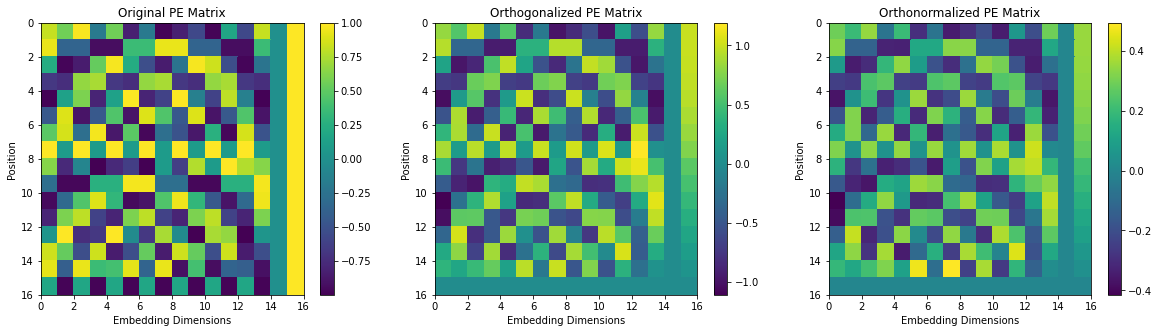

15


In [12]:
titles = ['Original PE Matrix', 'Orthogonalized PE Matrix', 'Orthonormalized PE Matrix']
pos_enc = pos_encode(PE_func = 1)
orthog = gs_orthogonalize(pos_enc)
orthon = normalize(orthog)

matrixlist = [pos_enc, orthog, orthon]
plotall(matrixlist, titles)

print(np.linalg.matrix_rank(pos_enc))


##Positional Encoding Function
For my positional encoding function I choose a simple linear spread of frequency

PE(pos, dim) = sin(freq\*pos) for even positions
PE(pos, dim) = cos(freq\*pos) for odd positions

My initial frequency was a 8 frequencies linearly spread from (0, 2pi].
However this results in there being two sin(pi) columns. The first at the middle where position is equal to 8 and freq is equal to n\*pi/8. The second is at the end where freq is 2\*pi.

Thus to avoid this, I offset all frequencies by an arbitrary small amount pi/17.

Thus the resulting matrix will have a much higher rank.

I initially wanted to achieve a full rank basis matrix as basis vectors are usually chosen such that they are linearly independent. However I think that I can not achieve that with a column of constant values. Nor can I remove this column of constant values without leaving out 2pi from my frequencies. I will settle for a rank of 15.


#Assignment Questions

2. If 𝐵 is a set of basis vectors, are the vectors orthogonal? Orthonomal? If not, make the basis vectors orthogonal and orthonormal using G-S method.

Ans. Do an orthogonal check by taking the dot product of the matrix with its transpose. If all non-diagonal entries are zero, the matrix is orthogonal, as this takes all the combinations of dot products between the rows.
https://stackoverflow.com/questions/23503667/how-to-detect-if-all-the-rows-of-a-non-square-matrix-are-orthogonal-in-python

In [13]:
matrixlist = [pos_enc, orthog, orthon]
titles = ['Original PE Matrix', 'Orthogonalized PE Matrix', 'Orthonormalized PE Matrix']
for i, zipitem in enumerate(zip(matrixlist,titles)):
    item, title = zipitem
    product = np.dot(item, item.T)
    np.fill_diagonal(product, 0)
    print(title,":", product.min(),product.max())

for i, zipitem in enumerate(zip(matrixlist,titles)):
    
    item, titles = zipitem
    ave = []
    for j in range(item.shape[0]):
        ave.append(np.linalg.norm(item[i]))
    print(ave)


Original PE Matrix : 0.0 1.932472229404331
Orthogonalized PE Matrix : -1.0327724963310994e-15 1.0292251486903762e-15
Orthonormalized PE Matrix : -1.6386713902780805e-16 1.9933974684008467e-16
[2.8284271247461903, 2.8284271247461903, 2.8284271247461903, 2.8284271247461903, 2.8284271247461903, 2.8284271247461903, 2.8284271247461903, 2.8284271247461903, 2.8284271247461903, 2.8284271247461903, 2.8284271247461903, 2.8284271247461903, 2.8284271247461903, 2.8284271247461903, 2.8284271247461903, 2.8284271247461903]
[2.828420718454594, 2.828420718454594, 2.828420718454594, 2.828420718454594, 2.828420718454594, 2.828420718454594, 2.828420718454594, 2.828420718454594, 2.828420718454594, 2.828420718454594, 2.828420718454594, 2.828420718454594, 2.828420718454594, 2.828420718454594, 2.828420718454594, 2.828420718454594]
[0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0

###Orthogonality
For the original matrix, the maximum value of the dot product of itself with its transpose (not including the diagonal entries) is ~1.9, thus it is NOT orthogonal.

For the GS orthogonalized matrix, the maximum value of the dot product of itself with its transpose (not including the diagonal entries) is sufficiently close to 0 to assure me that the matrix is orthogonal.

The same holds true for the GS normalized matrix.

###Normalization
For the original matrix, the norms of its rows is not 1.

For the orthogonalized matrix, the norms of its rows is still not 1.

For the orthonormalized matrix, the norms of its rows is finally 1.

#Deprecated Code
Previously used for different PE encodings

In [7]:
##Previous PE_func implementations
'''#Code from: https://github.com/jalammar/jalammar.github.io/tree/master/notebookes/transformer
#Used for PE_func = 2
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return pos_encoding
'''
'''
        PE_func 2: Same positional encoding as reference code and the paper
                    it tries to reimplement.
                    Code from: https://github.com/jalammar/jalammar.github.io/tree/master/notebookes/transformer
        PE_func 3: Same positional encoding as reference code and paper BUT
                    the FREQUENCY of cos and sine is made to vary from 0 to 2pi.
                    For reference the original PE varies the WAVELENGTHS from
                    2pi to 10000*2pi
'''
'''
if PE_func == 2:
        angle_rads = get_angles(np.arange(num_positions)[:, np.newaxis],
                        np.arange(enc_dimensions)[np.newaxis, :],
                        enc_dimensions)
  
        # apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
            
        pos_enc_mat = angle_rads
            

    if PE_func == 3:
        
        pos_enc_mat = np.zeros((num_positions, enc_dimensions))
        freq_exp = np.arange(0, 8 + 8/7, 8/7)
        frequencies = (2*pi)**(2*freq_exp/enc_dimensions)
        
        positions = np.arange(0,16)

        for i in range(num_positions):
            #for row i using sin for even columns cosine for odd
            pos_enc_mat[i, 0::2] = np.sin(frequencies*positions[i])
            pos_enc_mat[i, 1::2] = np.cos(frequencies*positions[i])
            
    return pos_enc_mat
'''

'\nif PE_func == 2:\n        angle_rads = get_angles(np.arange(num_positions)[:, np.newaxis],\n                        np.arange(enc_dimensions)[np.newaxis, :],\n                        enc_dimensions)\n  \n        # apply sin to even indices in the array; 2i\n        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])\n\n        # apply cos to odd indices in the array; 2i+1\n        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])\n            \n        pos_enc_mat = angle_rads\n            \n\n    if PE_func == 3:\n        \n        pos_enc_mat = np.zeros((num_positions, enc_dimensions))\n        freq_exp = np.arange(0, 8 + 8/7, 8/7)\n        frequencies = (2*pi)**(2*freq_exp/enc_dimensions)\n        \n        positions = np.arange(0,16)\n\n        for i in range(num_positions):\n            #for row i using sin for even columns cosine for odd\n            pos_enc_mat[i, 0::2] = np.sin(frequencies*positions[i])\n            pos_enc_mat[i, 1::2] = np.cos(frequencies*positions[i])\n    